## TP n° 1 : Manipulation de données audio : classification stylistique
### Auteur : Jad El Karchi

### - Partie 1 : Manipulation de fichiers audio

audio time series :[1.0904326e-03 1.3623741e-03 1.4456341e-03 ... 4.1513053e-06 4.0163877e-06
 3.6187041e-06];
number of values : 11819689;
sampling rate : 44100;

Deduced audio duration : 268.0202 seconds;
Audio duration from file system : 268 seconds.


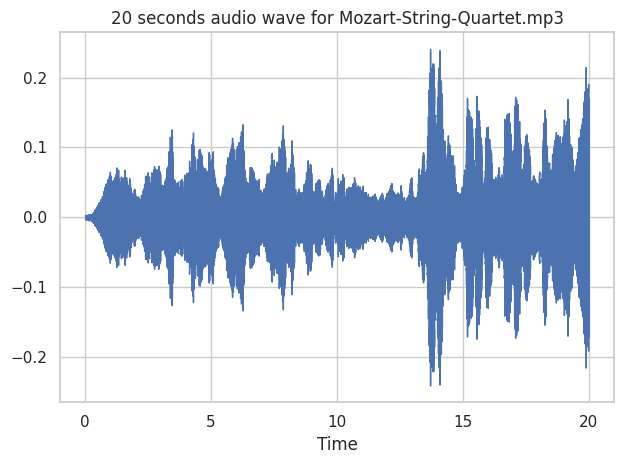

In [48]:
from playsound import playsound
import matplotlib.pyplot as plt
import seaborn as sns
from librosa import load
from librosa.display import waveshow, specshow

path_to_audio = f'./audio/classique/Mozart-String-Quartet.mp3'

# play your audio (uncomment to hear)
# playsound(path_to_audio)

# load your audio
audio_ts, sr = load(path_to_audio, sr=None)
print(f"audio time series :{audio_ts};\nnumber of values : {len(audio_ts)};\nsampling rate : {sr};\n")

audio_duration = len(audio_ts) / sr
print(f"Deduced audio duration : {audio_duration:.4f} seconds;\nAudio duration from file system : {268} seconds.")

# load only the first 20 seconds
audio_data =  load(path_to_audio, duration=20.0, sr=None)
ts, sr = audio_data


sns.set_style("whitegrid")
waveshow(ts, sr=sr, max_points=4000, color='b')
plt.title(f"20 seconds audio wave for {path_to_audio.split('/')[-1]}")
plt.tight_layout()

### - Partie 2 : Représentation MFCCs

matrice MFCC  : [[-6.3108276e+02 -6.2340741e+02 -6.2859424e+02 ... -4.2355289e+02
  -4.1231015e+02 -4.0191470e+02]
 [ 9.0284470e+01  7.9042953e+01  7.0759689e+01 ...  2.1299614e+02
   2.1250070e+02  2.0048016e+02]
 [ 2.1121704e+01  6.2669034e+00  3.9824300e+00 ... -1.7736706e+01
  -2.0703897e+01 -1.3364901e+01]
 ...
 [ 5.2292485e+00  1.9074188e+01  2.9117146e+01 ... -4.4705477e+00
  -5.2679420e+00 -5.8305111e+00]
 [ 7.9767876e+00  1.3579590e+01  1.9681328e+01 ...  4.2926445e+00
   2.1332188e+00  1.1907628e-01]
 [ 7.1455936e+00  9.1085815e-01  2.9571545e+00 ... -3.4895406e+00
  -5.8292809e+00 -1.3436276e+00]], of shape : (12, 862)
86.2 valeurs calculées pour 1 seconde pour 1 coef.
1 valeur dans MFCC dans 1 coef correspond 511.6009280742459 échantillons.


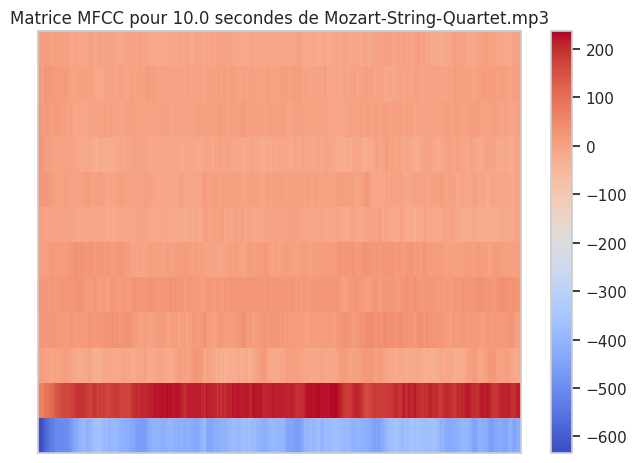

In [49]:
from librosa.feature import mfcc

n_bande_freq = 12
duration_ = 10.0

ts, sr = load(path_to_audio, duration=duration_, sr=None)
mfcc_ = mfcc(y=ts, sr=sr, n_mfcc=n_bande_freq)
print(f"matrice MFCC  : {mfcc_}, of shape : {mfcc_.shape}")

print(f"{mfcc_.shape[1] / duration_} valeurs calculées pour 1 seconde pour 1 coef.")
print(f"1 valeur dans MFCC dans 1 coef correspond {sr / (mfcc_.shape[1] / duration_)} échantillons.")

specshow(mfcc_, sr=sr)
plt.title(f"Matrice MFCC pour {duration_} secondes de {path_to_audio.split('/')[-1]}")
plt.colorbar()
plt.tight_layout()

### - Partie 3 : Préparation des descripteurs

écart-types : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
moyennes : [ 0.0000000e+00  0.0000000e+00  4.4254027e-09  1.7701611e-08
 -2.2127014e-09 -8.8508054e-09  0.0000000e+00 -2.6552417e-08
  1.1063507e-08  6.6381043e-09  4.4254027e-09  1.3276209e-08]


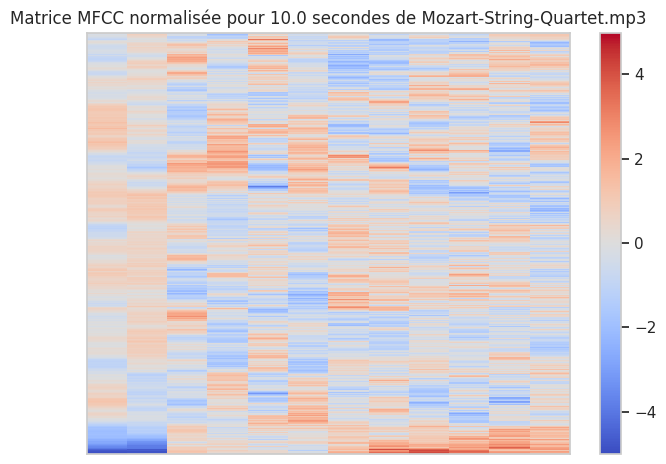

In [50]:
from sklearn.preprocessing import StandardScaler
import numpy as np

std_scaler = StandardScaler()
mfcc_T = mfcc_.T # (n_samples, n_features)
mfcc_std = std_scaler.fit_transform(mfcc_T)

specshow(mfcc_std, sr=sr)
plt.title(f"Matrice MFCC normalisée pour {duration_} secondes de {path_to_audio.split('/')[-1]}")
plt.colorbar()
plt.tight_layout()

print(f"écart-types : {np.std(mfcc_std, axis=0)}")
print(f"moyennes : {np.mean(mfcc_std, axis=0)}")

### - Partie 4 : Entraînement d'un modèle

In [51]:
import pandas as pd
from sklearn.svm import SVC

np.random.seed(123)

def get_mfcc(fnames, n_desc, duration, offset=0.0) :
    acc = []
    for fname in fnames :
        ts, sr = load(fname, sr=None, duration=duration, offset=offset)
        mfcc_ = mfcc(y=ts, sr=sr, n_mfcc=n_desc)
        std_scaler = StandardScaler()
        mfcc_T = mfcc_.T # (n_samples, n_features)
        mfcc_std = std_scaler.fit_transform(mfcc_T)
        acc.append(mfcc_std)
    return acc


def create_df(mfccs, targets) :
    merged_mfccs = np.concatenate(mfccs, axis=0)
    merged_targets = np.concatenate(targets)

    indices = np.arange(merged_mfccs.shape[0])
    np.random.shuffle(indices)

    shuffled_mfccs = merged_mfccs[indices]
    shuffled_targets = merged_targets[indices]

    # Create a DataFrame
    data = pd.DataFrame(shuffled_mfccs)
    data['target'] = shuffled_targets
    column_names = [f'mfcc_{i}' for i in range(1, merged_mfccs.shape[1] + 1)]
    column_names.append('target')

    return data

def train_SVC(data) :
    X_train = data.drop('target', axis=1)
    y_train = data['target']
    svm_clf = SVC(C=1.0, kernel='rbf', random_state=42)
    svm_clf.fit(X_train, y_train)
    return svm_clf

n_desc = 12
duration = 20.0
fnames = ["./audio/classique/Mozart-String-Quartet.mp3", "./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3"]

mfccs = get_mfcc(fnames, n_desc, duration)
targets = [np.zeros(mfccs[0].shape[0], dtype=int), np.ones(mfccs[1].shape[0], dtype=int)]
data = create_df(mfccs, targets)

# Training
svm_clf = train_SVC(data)

data

,0,1,2,3,4,5,6,7,8,9,10,11,target
0,-0.897813,0.253237,0.669416,-1.463886,0.050410,0.721128,1.420921,0.434773,1.663167,0.218922,1.158160,-1.066132,1
1,0.438281,-0.063371,-0.676962,0.446071,0.210544,1.268671,-1.029396,-1.891118,-0.102708,1.413085,0.113073,0.085511,1
2,-0.353983,-1.463744,-0.377481,0.301073,-0.710787,0.299355,-0.729840,1.210773,0.341404,-1.324216,0.899984,-0.103957,0
3,0.942006,0.384628,-1.077206,-0.596970,-0.849578,-0.538460,-0.060093,-1.752539,-1.303123,0.226348,-1.238401,-0.019606,0
4,1.849490,-0.195799,-0.819048,0.737593,-1.465485,1.577425,-1.097667,1.521839,-1.405472,0.063423,-1.438172,1.399322,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,-2.199341,0.100223,2.516501,0.054613,2.717686,-0.149618,2.119434,0.130670,1.330083,0.397159,1.686585,0.298092,1
3442,-0.209395,0.597521,0.379473,-0.456814,-0.325976,-1.616540,-1.007008,-1.033117,-0.135802,-0.998008,0.139461,0.097042,1
3443,-0.447408,-1.213484,-0.255285,-0.823273,-0.956592,1.170226,1.233634,1.704861,0.761208,1.800050,0.055879,-1.502135,0
3444,1.520141,0.643265,-1.016546,-0.570104,-1.689536,-0.380300,-1.340153,-0.494344,-1.190821,-3.062795,-1.397328,-0.243062,0


### - Partie 5 : Évaluation d'un modèle

classification report :
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       431
           1       0.75      0.87      0.81       431

    accuracy                           0.79       862
   macro avg       0.80      0.79      0.79       862
weighted avg       0.80      0.79      0.79       862



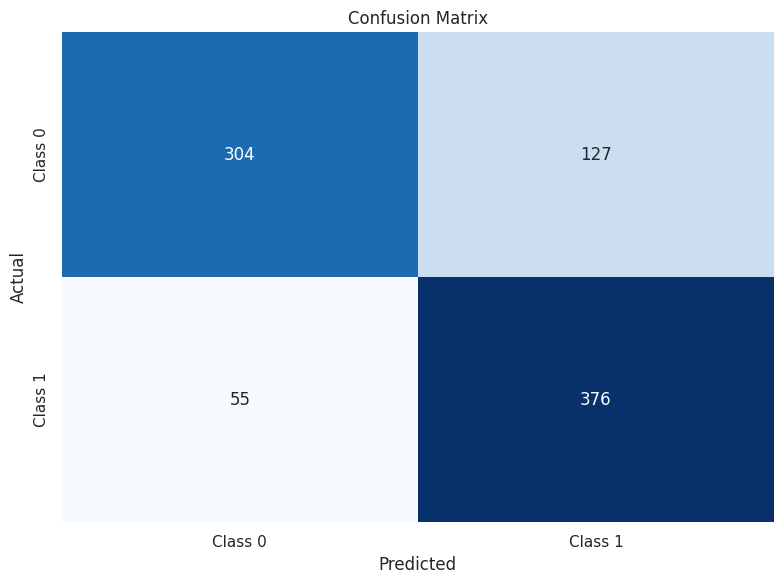

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
import seaborn as sns

sns.set_style("whitegrid")

n_desc = 12
test_duration = 5.0
test_fnames = ["./audio/classique/Mozart-String-Quartet.mp3", "./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3"]

test_mfccs = get_mfcc(test_fnames, n_desc, test_duration, offset=20.0)
test_targets = [np.zeros(test_mfccs[0].shape[0], dtype=int), np.ones(test_mfccs[1].shape[0], dtype=int)]
test_data = create_df(test_mfccs, test_targets)

X_test = test_data.drop('target', axis=1)
y_test = test_data['target']

y_pred = svm_clf.predict(X_test)
print(f"classification report :\n{classification_report(y_true=y_test, y_pred=y_pred)}")



y_pred = svm_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()

### - Partie 6 : Expériences

In [53]:
# parameters
mfccs_coefs = [4, 8, 16, 32, 64, 128]
fnames = ["./audio/classique/Haydn-String-Quartet.mp3",
          "./audio/classique/Mozart-String-Quartet.mp3",
          "./audio/flamenco/Paco-De-Lucia-Rio-Ancho.mp3",
          "./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3",
          "./audio/punk/Millencolin-No_Cigar.mp3",
          "./audio/punk/The-Offspring-The-Kids-Arent-Alright.mp3"]
n_class_styles = [0, 0, 1, 1, 2, 2]
n_class = range(6)
train_durations = [2.0, 5.0, 10.0, 20.0, 30.0, 45.0]
test_duration = 5.0

def get_targets(mfccs, n_class) :
    return [np.full(mfccs[i].shape[0], dtype=int, fill_value=i) for i in n_class]
    

def fine_tune_SVC(mfccs_coefs, train_durations, n_class, test_duration) :
    precision_list, recall_list, n_desc_list, train_duration_list = [], [], [], []

    # Fine tuning loop
    for n_desc in mfccs_coefs :
        for train_duration in train_durations :
            print(f"params : {n_desc} coefs; {train_duration} training seconds.")
            mfccs = get_mfcc(fnames, n_desc, duration)
            targets = get_targets(mfccs, n_class)
            data = create_df(mfccs, targets)
            svm_clf = train_SVC(data)
            
            test_mfccs = get_mfcc(fnames, n_desc, test_duration, offset=train_duration)
            test_targets = get_targets(test_mfccs, n_class)
            test_data = create_df(test_mfccs, test_targets)

            X_test = test_data.drop('target', axis=1)
            y_test = test_data['target']
            y_pred = svm_clf.predict(X_test)
        
            n_desc_list.append(n_desc)
            train_duration_list.append(train_duration)
            precision_list.append(precision_score(y_test, y_pred, average='weighted'))
            recall_list.append(recall_score(y_test, y_pred, average='weighted'))
            
    return precision_list, recall_list, n_desc_list, train_duration_list
        


precision_list, recall_list, n_desc_list, train_duration_list = fine_tune_SVC(mfccs_coefs, train_durations, n_class, test_duration)

params : 4 coefs; 2.0 training seconds.
params : 4 coefs; 5.0 training seconds.
params : 4 coefs; 10.0 training seconds.
params : 4 coefs; 20.0 training seconds.
params : 4 coefs; 30.0 training seconds.
params : 4 coefs; 45.0 training seconds.
params : 8 coefs; 2.0 training seconds.
params : 8 coefs; 5.0 training seconds.
params : 8 coefs; 10.0 training seconds.
params : 8 coefs; 20.0 training seconds.
params : 8 coefs; 30.0 training seconds.
params : 8 coefs; 45.0 training seconds.
params : 16 coefs; 2.0 training seconds.
params : 16 coefs; 5.0 training seconds.
params : 16 coefs; 10.0 training seconds.
params : 16 coefs; 20.0 training seconds.
params : 16 coefs; 30.0 training seconds.
params : 16 coefs; 45.0 training seconds.
params : 32 coefs; 2.0 training seconds.
params : 32 coefs; 5.0 training seconds.
params : 32 coefs; 10.0 training seconds.
params : 32 coefs; 20.0 training seconds.
params : 32 coefs; 30.0 training seconds.
params : 32 coefs; 45.0 training seconds.
params : 64 

,n_desc,train_duration,precision,recall
31,128,5.0,0.945650,0.938902
32,128,10.0,0.942079,0.931941
30,128,2.0,0.899814,0.886311
25,64,5.0,0.867260,0.851121
26,64,10.0,0.842033,0.819799
24,64,2.0,0.766602,0.715391
19,32,5.0,0.688100,0.699149
20,32,10.0,0.682213,0.658933
33,128,20.0,0.620553,0.519335
18,32,2.0,0.594050,0.591647


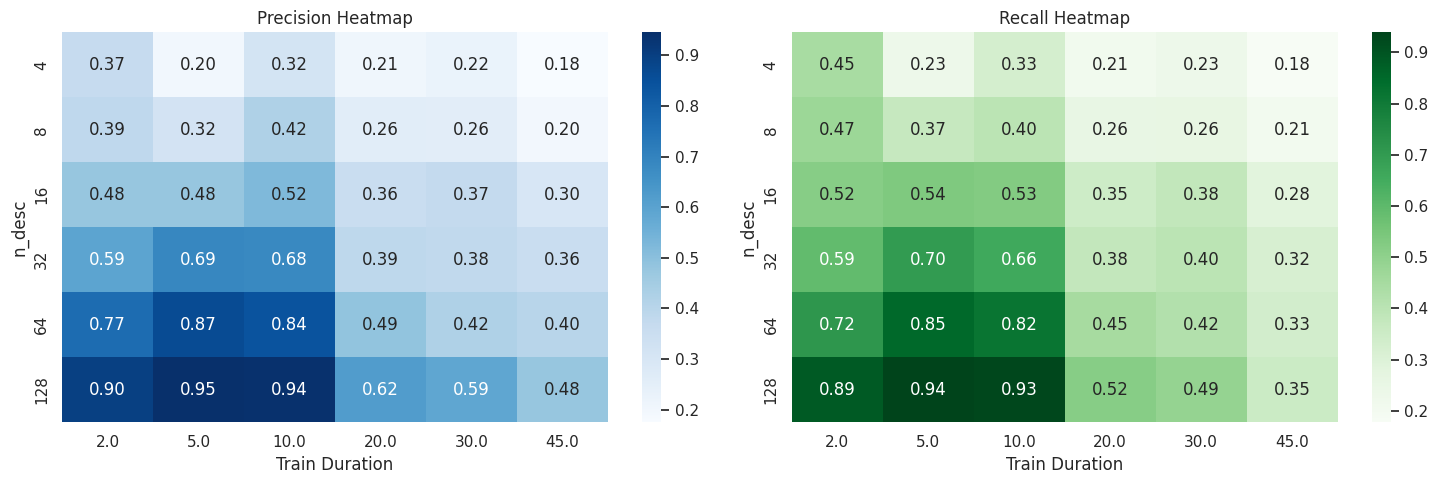

In [54]:

def plot_fine_tune_results(precision_list, recall_list, n_desc_list, train_duration_list) :
    result_df = pd.DataFrame({
        'n_desc': n_desc_list,
        'train_duration': train_duration_list,
        'precision': precision_list,
        'recall': recall_list
    })

    # Pivot DataFrames to create matrices for heatmap
    precision_matrix = result_df.pivot(index='n_desc', columns='train_duration', values='precision')
    recall_matrix = result_df.pivot(index='n_desc', columns='train_duration', values='recall')

    # Plot heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    sns.heatmap(precision_matrix, cmap='Blues', annot=True, fmt='.2f', ax=ax1)
    ax1.set_title('Precision Heatmap')
    ax1.set_xlabel('Train Duration')
    ax1.set_ylabel('n_desc')

    sns.heatmap(recall_matrix, cmap='Greens', annot=True, fmt='.2f', ax=ax2)
    ax2.set_title('Recall Heatmap')
    ax2.set_xlabel('Train Duration')
    ax2.set_ylabel('n_desc')
    plt.tight_layout()
    
    return result_df


result_df = plot_fine_tune_results(precision_list, recall_list, n_desc_list, train_duration_list)

# display sorted results
result_df.sort_values(["precision", "recall"], ascending=False)

### - Bonus : Classification par style de musique, Classic VS Flamenco VS Punk

params : 4 coefs; 2.0 training seconds.
params : 4 coefs; 5.0 training seconds.
params : 4 coefs; 10.0 training seconds.
params : 4 coefs; 20.0 training seconds.
params : 4 coefs; 30.0 training seconds.
params : 4 coefs; 45.0 training seconds.
params : 8 coefs; 2.0 training seconds.
params : 8 coefs; 5.0 training seconds.
params : 8 coefs; 10.0 training seconds.
params : 8 coefs; 20.0 training seconds.
params : 8 coefs; 30.0 training seconds.
params : 8 coefs; 45.0 training seconds.
params : 16 coefs; 2.0 training seconds.
params : 16 coefs; 5.0 training seconds.
params : 16 coefs; 10.0 training seconds.
params : 16 coefs; 20.0 training seconds.
params : 16 coefs; 30.0 training seconds.
params : 16 coefs; 45.0 training seconds.
params : 32 coefs; 2.0 training seconds.
params : 32 coefs; 5.0 training seconds.
params : 32 coefs; 10.0 training seconds.
params : 32 coefs; 20.0 training seconds.
params : 32 coefs; 30.0 training seconds.
params : 32 coefs; 45.0 training seconds.
params : 64 

,n_desc,train_duration,precision,recall
31,128,5.0,0.945650,0.938902
32,128,10.0,0.942079,0.931941
30,128,2.0,0.899814,0.886311
25,64,5.0,0.866910,0.850735
26,64,10.0,0.842289,0.820186
24,64,2.0,0.766602,0.715391
19,32,5.0,0.688100,0.699149
20,32,10.0,0.682213,0.658933
33,128,20.0,0.620456,0.518948
18,32,2.0,0.594050,0.591647


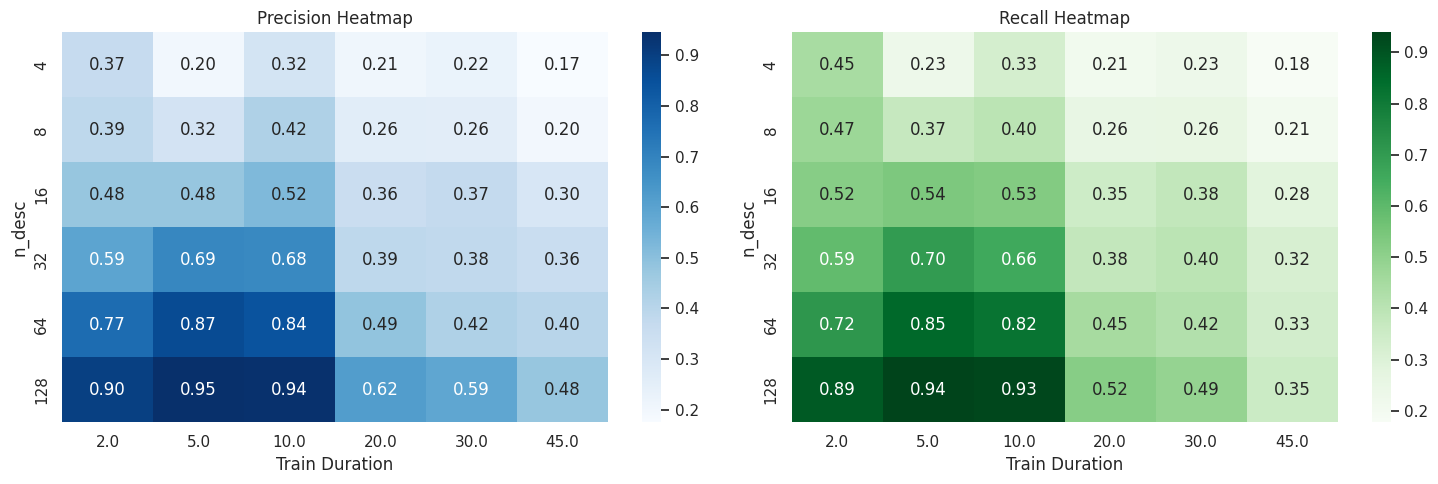

In [55]:
# parameters
mfccs_coefs = [4, 8, 16, 32, 64, 128]
fnames = ["./audio/classique/Haydn-String-Quartet.mp3",
          "./audio/classique/Mozart-String-Quartet.mp3",
          "./audio/flamenco/Paco-De-Lucia-Rio-Ancho.mp3",
          "./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3",
          "./audio/punk/Millencolin-No_Cigar.mp3",
          "./audio/punk/The-Offspring-The-Kids-Arent-Alright.mp3"]
n_class_styles = [0, 0, 1, 1, 2, 2] # 0 = classique, 1 = flamenco, 2 = punk (we can also use onehot encoding for this)
train_durations = [2.0, 5.0, 10.0, 20.0, 30.0, 45.0]
test_duration = 5.0

precision_list, recall_list, n_desc_list, train_duration_list = fine_tune_SVC(mfccs_coefs, train_durations, n_class, test_duration)
result_df = plot_fine_tune_results(precision_list, recall_list, n_desc_list, train_duration_list)

# display sorted results
result_df.sort_values(["precision", "recall"], ascending=False)

### - Bonus : Unsupervised Learning, clusters de chaque style de musique

,PCA1,PCA2,songs
0,-8.063858,0.522509,2
1,0.584519,0.421271,5
2,-5.959185,0.594586,2
3,-0.548615,1.373207,0
4,-0.548615,1.373204,0
...,...,...,...
2581,-3.400655,-0.144803,2
2582,1.921272,3.154669,5
2583,0.264125,-0.957807,5
2584,-0.801567,-1.696266,4


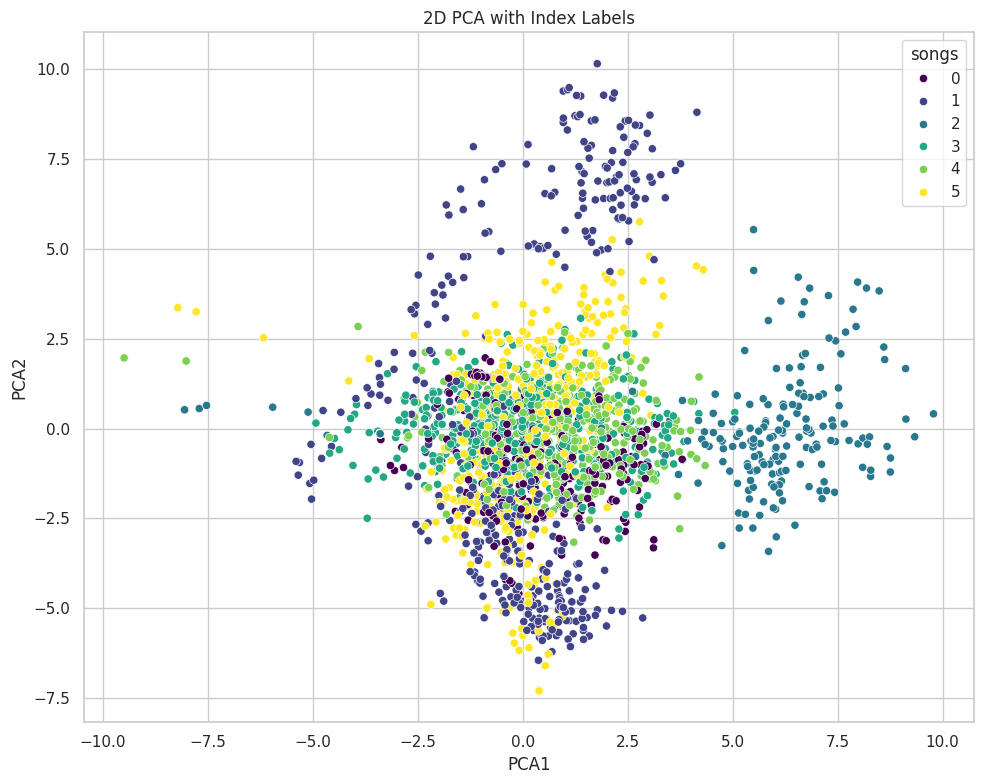

In [59]:
from sklearn.decomposition import PCA

Best_params = {'mfcc_coef' : 128, 'train_duration' : 5.0}

mfccs_2 = get_mfcc(fnames, Best_params['mfcc_coef'], Best_params['train_duration'])
targets_2 = get_targets(mfccs_2, n_class)
data_2 = create_df(mfccs_2, targets_2)

# Extracting features
features = data_2.drop('target', axis=1)
target = data_2['target']
pca = PCA(n_components=2)

def apply_PCA_to_features(pca, features, target_column) :

    # Applying PCA
    pca_result = pca.fit_transform(features)

    # Creating a new DataFrame with PCA results and target labels
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
    pca_df['songs'] = target_column

    mean_by_target = pca_df#.groupby('songs').mean() # calculate mean to get the coordinates of style
    
    # Plotting using Seaborn with whitegrid style
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PCA1', y='PCA2', hue='songs', data=mean_by_target, palette='viridis')
    plt.title('2D PCA with Index Labels')
    plt.tight_layout()
    
    return mean_by_target

pca_df = apply_PCA_to_features(pca, features, target)

pca_df